# Tunnel+

***Goal***: To make an improved version of [Location+](https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/) that incorporates pitch tunneling. <br>
**Author**: Jensen Holm <br>
**Date**: 2024

In [1]:
!pip install git+https://github.com/Jensen-holm/statcast-era-pitches.git

  Cloning https://github.com/Jensen-holm/statcast-era-pitches.git to /tmp/pip-req-build-9amdkiyz
  Running command git clone --filter=blob:none --quiet https://github.com/Jensen-holm/statcast-era-pitches.git /tmp/pip-req-build-9amdkiyz
  Resolved https://github.com/Jensen-holm/statcast-era-pitches.git to commit 6ff4dcb3e47835ef8efbfd8fcddbe490d54fd7ae
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import statcast_pitches
import polars as pl
from plotnine import *
import plotly.express as px

## Loading Data

Using all pitches thrown in the statcast-era (2015-present) as our data for this model. <br>
I will also be using `../data/run_values.csv` for calculating run values of each pitch, this data represents 2024 only.

**Data Dictionary**: [link](https://baseballsavant.mlb.com/csv-docs) <br>
**statcast_pitches package info**: [link](https://github.com/Jensen-holm/statcast-era-pitches)

In [3]:
# use statcast pitches to get all pitches thrown in since hawkeye began
pitches_lf: pl.LazyFrame = (statcast_pitches.load()
                            .filter(pl.col("game_date").dt.year() >= 2017))

latest_date = pitches_lf.select("game_date").max().collect().item().date()
earliest_date = pitches_lf.select("game_date").min().collect().item().date()
n_pitches = pitches_lf.select(pl.len()).collect().item()

print(f"N Pitches: {n_pitches}")
print(f"Date Range: {earliest_date} - {latest_date}")

N Pitches: 5573157
Date Range: 2017-04-02 - 2024-10-30


In [4]:
run_values_24 = pl.scan_csv(
    "https://raw.githubusercontent.com/Jensen-holm/tunnel-plus/refs/heads/main/data/run_values.csv",
).rename({"event": "events"}) # it is called 'events' in pitches_df

## Feature Engineering

adding the following features to `pitches_df`

| Feature Name | Description |
|------|-------------|
| **delta_run_exp** | run value associated with the pitch outcome from `run_values_24`|
| **x_0.120** | position in the x dimension of the pitch at decision time (~0.12s) |
| **y_0.120** | position in the y dimension of the pitch at decision time (~0.12s) |
| **z_0.120** | position in the z dimension of the pitch at decision time (~0.12s) |
| **x_0.167** | position in the x dimension of the pitch at commit time (~0.167s) |
| **y_0.167** | position in the y dimension of the pitch at commit time (~0.167s) |
| **z_0.167** | position in the z dimension of the pitch at commit time (~0.167s) |
| **velocity_diff** | difference in velocity between pitches in a two pitch sequence |
| **effective_velocity_diff** | difference in effective velocity between pitches in a two pitch sequence |
| **pfx_x_diff** | difference in horizontal movement between pitches in a two pitch sequence |
| **pfx_z_diff** | difference in vertical movement between pitches in a two pitch sequence |
| **3d_dist_0.167** | 3D euclidean distance between pitches in a two pitch sequence 0.167 seconds after release |
| **3d_dist_0.120** | 3D distance between pitches in a two pitch sequence at 0.120 seconds after release |
| **distance** | 2D euclidean distance between pitch locations when crossing the plate in a two pitch sequence |
| **seq_delta_run_exp** | sum of `delta_run_exp` in a two pitch sequence |
| **plate_x_diff** | difference in plate_x between pitches in a two pitch sequence |
| **plate_z_diff** | difference in plate_z between pitches in a two pitch sequence |

On top of adding these features, attributes from LHP should be mirrored as if they were thrown by a RHP for consistency

Adding `delta_run_exp` first

In [5]:

description_replace_mapping = {
    "Ball": "ball",
    "In play, run(s)": "hit_into_play",
    "In play, out(s)": "hit_into_play",
    "In play, no out": "hit_into_play",
    "Called Strike": "called_strike",
    "Foul": "foul",
    "Swinging Strike": "swinging_strike",
    "Blocked Ball": "ball",
    "Swinging Strike (Blocked)": "swinging_strike",
    "Foul Tip": "swinging_strike",
    "Foul Bunt": "foul",
    "Hit By Pitch": "hit_by_pitch",
    "Pitchout": "ball",
    "Missed Bunt": "swinging_strike",
    "Bunt Foul Tip": "swinging_strike",
    "Foul Pitchout": "foul",
    "Ball In Dirt": "ball",
}


def add_pitch_run_value(lf: pl.LazyFrame) -> pl.LazyFrame:
    """Takes in a dataframe of pitches, and adds 2024 run value to each one"""
    pitch_runs_lf = lf.join(
        other=run_values_24,
        on=["events", "balls", "strikes"],
        how="left",
    )

    mapped_des_pitches = pitch_runs_lf.with_columns([
        pl.col("description")
        .replace_strict(description_replace_mapping, default=None)
        .alias("play_des"),
    ])

    pitches_run_value_lf = mapped_des_pitches.join(
        other=run_values_24,
        right_on=["events", "balls", "strikes"],
        left_on=["play_des", "balls", "strikes"],
        how="left",
        suffix="_des",
    ).with_columns([
        pl.when(pl.col("delta_run_exp").is_null())
        .then(pl.col("delta_run_exp_des"))
        .otherwise(pl.col("delta_run_exp"))
        .alias("delta_run_exp"),
    ])
    return pitches_run_value_lf

pitches_run_value_lf = pitches_lf.pipe(add_pitch_run_value)
pitches_run_value_lf.select(
    "pitch_type",
    "description",
    "balls",
    "strikes",
    "delta_run_exp",
).describe()

statistic,pitch_type,description,balls,strikes,delta_run_exp
str,str,str,f64,f64,f64
"""count""","""5477692""","""5573157""",5.573157e6,5.573157e6,5.383124e6
"""null_count""","""95465""","""0""",0.0,0.0,190033.0
"""mean""",null,null,0.875817,0.891433,0.000004
"""std""",null,null,0.96787,0.827898,0.243725
"""min""","""CH""","""ball""",0.0,0.0,-1.661
"""25%""",null,null,0.0,0.0,-0.067
"""50%""",null,null,1.0,1.0,-0.018
"""75%""",null,null,1.0,2.0,0.037
"""max""","""SV""","""swinging_strike_blocked""",4.0,3.0,3.702


Mirroring LHP metrics as if they were thrown by RHP

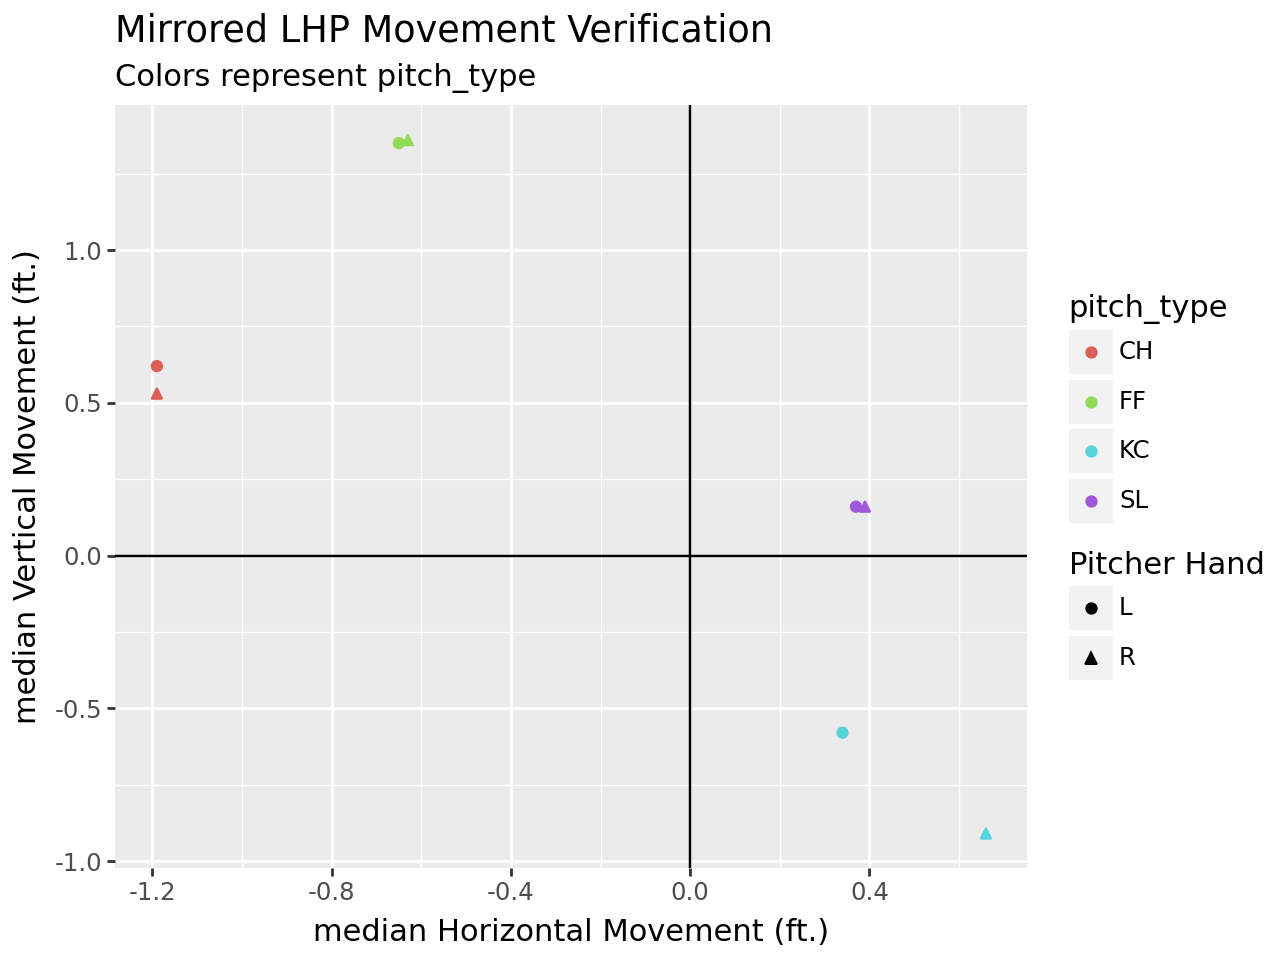

In [6]:
def mirror_lhp_to_rhp(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        # mirror LHP horizontal movement
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("pfx_x"))
        .otherwise(pl.col("pfx_x")),
    )

mirrored_pitches_lf = pitches_run_value_lf.pipe(mirror_lhp_to_rhp)

# for verification
movement_plt = (
    ggplot(
        mirrored_pitches_lf
        .filter(pl.col("pitch_type").is_in(["FF", "KC", "SL", "CH"]))
        .group_by("pitch_type", "p_throws")
        .agg(
            pl.col("pfx_x").median().alias("median_pfx_x"),
            pl.col("pfx_z").median().alias("median_pfx_z"),
        ).collect(),
        aes(x="median_pfx_x", y="median_pfx_z", color="pitch_type", shape="p_throws"))
    + geom_point()
    + geom_vline(xintercept=0)
    + geom_hline(yintercept=0)
    + labs(
        title="Mirrored LHP Movement Verification",
        x="median Horizontal Movement (ft.)",
        y="median Vertical Movement (ft.)",
        shape="Pitcher Hand",
        subtitle="Colors represent pitch_type",
    )
)

movement_plt.show()

Horizontal movement profiles are mirrored now!

## 3D Pitch Displacement

Now to add ball positions in 3D space at both [decision time]() (0.12s) & [commit time]() (0.167s)

Plugging in our pitch data into the kinematic equation for displacement below, I can solve for where the ball

$d = pos_{i} + v_{i} * t + \frac{1}{2} * a * t^{2}$

**where**:
- $t$ = time (seconds)
- $v_{i}$ = velocity at time $t$ in dimension $i$
- $a_{i}$ = acceleration at time $t$ in dimension $i$
- $pos_{i}$ = start position in dimension $i$

**Steps**:

For a given time $t$ ...

1. Estimate how many feet the ball will travel in $t$ seconds (assuming acceleration = az)
2. Estimate the x and y positions of the ball at $t$ seconds (assuming acceleration = ax & ay)

In [11]:
def displacement(p0, v0, t, a):
    return p0 + v0 * t + 0.5 * a * t**2

def convert_release_y_to_ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        release_pos_y=pl.col("release_pos_y") / 12
    )

def time_to_50ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        ((((60 + 9/12) - 50) - pl.col("release_extension"))
        / pl.col("release_speed") * (5280/3600)).alias("t50")
    )

def estimate_pos_at_50ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"release_pos_{d}"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=pl.col("t50"),
        ).alias(f"{d}50")
        for d in ["x", "y", "z"]
    )

def estimate_ball_pos_at_t(lf: pl.LazyFrame, ts: list[float]) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=t - pl.col("t50"),
        ).alias(f"{d}_{t:.3f}")
        for d in ["x", "y", "z"]
        for t in ts
    )

ball_pos_lf = (mirrored_pitches_lf
               .pipe(convert_release_y_to_ft)
               .pipe(time_to_50ft)
               .pipe(estimate_pos_at_50ft)
               .pipe(estimate_ball_pos_at_t, [0.120, 0.167]))

(ball_pos_lf
    .select("t50", "x_0.120", "y_0.120", "z_0.120",
            "x_0.167", "y_0.167", "z_0.167")
    .describe())

statistic,t50,x_0.120,y_0.120,z_0.120,x_0.167,y_0.167,z_0.167
str,f64,f64,f64,f64,f64,f64,f64
"""count""",5.470509e6,5.470509e6,5.470509e6,5.470509e6,5.470509e6,5.470509e6,5.470509e6
"""null_count""",102648.0,102648.0,102648.0,102648.0,102648.0,102648.0,102648.0
"""mean""",0.075213,-0.518707,-10.870032,5.256073,-0.414433,-16.853435,4.993368
"""std""",0.01132,1.302806,1.052789,0.472627,1.104971,1.443968,0.518842
"""min""",-0.02183,-9.948612,-13.741008,-3.699136,-14.602316,-20.782253,-7.15327
"""25%""",0.067533,-1.444958,-11.700933,4.964298,-1.199918,-17.993977,4.654521
"""50%""",0.0741,-0.929388,-11.053724,5.25326,-0.694678,-17.107864,4.973921
"""75%""",0.081581,0.543196,-10.137316,5.551693,0.367911,-15.847232,5.312967
"""max""",0.344956,5.807651,0.123774,10.563748,5.838082,-1.805149,10.583566


In [12]:
median_ball_loc_df = (ball_pos_lf
                    .filter(pl.col("pitch_type").is_in(["FF", "KC", "CH"]))
                    .drop_nulls(subset=["plate_x", "plate_z", "pitch_type", "release_pos_x", "release_pos_z", "release_pos_y", "x50", "z50", "y50"])
                    .group_by("pitch_type")
                    .agg([
                        pl.col(feature).median().alias(f"median_{feature}")
                        for feature in [
                            "release_pos_x",
                            "release_pos_y",
                            "release_pos_z",
                            "plate_x",
                            "plate_z",
                            "x_0.120",
                            "y_0.120",
                            "z_0.120",
                            "x_0.167",
                            "y_0.167",
                            "z_0.167",
                            "x50",
                            "y50",
                            "z50",
                        ]
                    ])
                    .with_columns(pl.lit(0).alias("plate_y"))
                    .collect())

decision_time_fig = px.scatter_3d(
    median_ball_loc_df,
    x="median_x_0.120",
    y="median_y_0.120",
    z="median_z_0.120",
    color="pitch_type",
    symbol="pitch_type",
)

commit_time_fig = px.scatter_3d(
    median_ball_loc_df,
    x="median_x_0.167",
    y="median_y_0.167",
    z="median_z_0.167",
    color="pitch_type",
    symbol="pitch_type",
)

fig50 = px.scatter_3d(
    median_ball_loc_df,
    x="median_x50",
    y="median_y50",
    z="median_z50",
    color="pitch_type",
    symbol="pitch_type",
)

release_fig = px.scatter_3d(
    median_ball_loc_df,
    x="median_release_pos_x",
    y="median_release_pos_y",
    z="median_release_pos_z",
    color="pitch_type",
    symbol="pitch_type",
)

for fig in [decision_time_fig, commit_time_fig, release_fig, fig50]:
    decision_time_fig.add_traces(fig.data)

decision_time_fig.update_layout(
    title="Median Position at commit & decision times in pitch flight",
    scene=dict(
        xaxis_title="X (ft.)",
        yaxis_title="Y (ft.)",
        zaxis_title="Z (ft.)",
    )
).show()

Get pitch sequences and difference features

In [9]:
# features that we are interested in with regards to two pitch sequences
prev_features = [
    "prev_pfx_x",
    "prev_pfx_z",
    "prev_x_0.120",
    "prev_y_0.120",
    "prev_z_0.120",
    "prev_x_0.167",
    "prev_y_0.167",
    "prev_z_0.167",
    "prev_release_pos_x",
    "prev_release_pos_y",
    "prev_release_pos_z",
    "prev_release_speed",
    "prev_effective_speed",
    "prev_release_spin_rate",
    "prev_delta_run_exp",
    "prev_plate_x",
    "prev_plate_z",
]

def two_pitch_sequences(lf: pl.LazyFrame) -> pl.LazyFrame:
    # sort the data such that the pitches are in descending order
    sort_cols = ["pitcher", "game_date", "at_bat_number", "pitch_number"]
    sorted_lf = lf.sort(
        by=sort_cols,
        descending=True,
    )

    return (sorted_lf
        .with_columns([
            pl.col(feature)
            .shift(-1)
            .over(["pitcher", "at_bat_number"])
            .alias(f"prev_{feature}")
            # for feature in sorted_lf.collect_schema().names()
            for feature in [f.replace("prev_", "") for f in prev_features]
        ])
        .select(*sort_cols + prev_features)
        .join(other=lf, on=sort_cols, how="right")
    )

def add_diff_features(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        *[(pl.col(f"{dim}_{t:.3f}") - pl.col(f"prev_{dim}_{t:.3f}"))
          .alias(f"{dim}_diff_{t}")
            for dim in ["x", "y", "z"]
            for t in [0.120, 0.167]],
        (pl.col("release_speed") - pl.col("prev_release_speed")).alias("velocity_diff"),
        (pl.col("effective_speed") - pl.col("prev_effective_speed")).alias("effective_speed_diff"),
        (pl.col("pfx_x") - pl.col("prev_pfx_x")).alias("pfx_diff"),
        (pl.col("pfx_z") - pl.col("prev_pfx_z")).alias("pfx_z_diff"),
        (pl.col("delta_run_exp") + pl.col("prev_delta_run_exp")).alias("seq_delta_run_exp"),
        (pl.col("plate_x") - pl.col("prev_plate_x")).alias("plate_x_diff"),
        (pl.col("plate_z") - pl.col("prev_plate_z")).alias("plate_z_diff"),
        (((pl.col("plate_x") - pl.col("prev_plate_x") ** 2) +
         (pl.col("plate_z") - pl.col("prev_plate_z") ** 2)) ** 0.5).alias("distance"),
    )


sequence_pitches_lf = (ball_pos_lf
                       .pipe(two_pitch_sequences)
                       .pipe(add_diff_features))

(sequence_pitches_lf
    .select(prev_features)
    .describe())

statistic,prev_pfx_x,prev_pfx_z,prev_x_0.120,prev_y_0.120,prev_z_0.120,prev_x_0.167,prev_y_0.167,prev_z_0.167,prev_release_pos_x,prev_release_pos_y,prev_release_pos_z,prev_release_speed,prev_effective_speed,prev_release_spin_rate,prev_delta_run_exp,prev_plate_x,prev_plate_z
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",5.373162e6,5.373173e6,5.366766e6,5.366766e6,5.366766e6,5.366766e6,5.366766e6,5.366766e6,5.373027e6,5.373027e6,5.373027e6,5.3733e6,5.363033e6,5.319769e6,5.285069e6,5.373237e6,5.373237e6
"""null_count""",213421.0,213410.0,219817.0,219817.0,219817.0,219817.0,219817.0,219817.0,213556.0,213556.0,213556.0,213283.0,223550.0,266814.0,301514.0,213346.0,213346.0
"""mean""",-0.370602,0.649538,-0.21293,-29.69499,4.235461,-0.123648,-35.494435,3.802006,-0.797965,4.522861,5.835762,88.842504,88.749538,2244.009085,-0.000947,0.044019,2.268852
"""std""",0.812746,0.741587,0.789475,2.10254,0.637859,0.731837,2.229078,0.718339,1.898434,0.042515,0.527836,6.009734,6.244913,332.790261,0.234109,0.852319,0.968173
"""min""",-3.0,-2.79,-37.578053,-50.646824,-23.778486,-44.378948,-55.815257,-28.612886,-6.09,2.381667,-0.03,30.4,26.8,4.0,-1.661,-65.16,-45.11
"""25%""",-1.05,0.19,-0.754332,-31.118195,3.810257,-0.611765,-37.014122,3.325721,-2.14,4.494167,5.57,84.6,84.4,2091.0,-0.065,-0.53,1.64
"""50%""",-0.53,0.75,-0.258575,-29.725667,4.208782,-0.129699,-35.567908,3.778163,-1.51,4.521667,5.87,89.9,89.8,2267.0,-0.017,0.04,2.28
"""75%""",0.27,1.26,0.295758,-28.30614,4.630006,0.359003,-34.047624,4.251948,1.0,4.550833,6.17,93.6,93.6,2438.0,0.037,0.62,2.91
"""max""",2.95,2.99,9.170664,-5.840184,14.705674,9.523633,-11.800331,14.733551,18.0,4.995,10.54,105.1,194.6,3741.0,3.702,11.3,13.58


3D euclidean distances between the baseball at decision and commit points

$3Deuclideandistance = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}$

In [10]:

def add_3D_distances(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        # decision & commit time distances
        (((pl.col(f"x_{t:.3f}") - pl.col(f"prev_x_{t:.3f}")) ** 2)
        + ((pl.col(f"y_{t:.3f}") - pl.col(f"prev_y_{t:.3f}")) ** 2)
        + ((pl.col(f"z_{t:.3f}") - pl.col(f"prev_z_{t:.3f}")) ** 2)
        ** 0.5).alias(f"3d_dist_{t:.3f}")
        for t in [0.120, 0.167]
    )

sequence_dist_pitches_lf = sequence_pitches_lf.pipe(add_3D_distances)

(sequence_dist_pitches_lf
    .select("3d_dist_0.120", "3d_dist_0.167")
    .describe())

statistic,3d_dist_0.120,3d_dist_0.167
str,f64,f64
"""count""",5.333821e6,5.333821e6
"""null_count""",252762.0,252762.0
"""mean""",3.008589,4.179661
"""std""",3.717747,5.028033
"""min""",0.0,0.0
"""25%""",1.028806,1.294774
"""50%""",1.940334,2.555331
"""75%""",3.713664,5.27174
"""max""",1625.922951,2223.911
